In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


#import

In [2]:
import glob, cv2, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.applications.resnet50 import ResNet50

#データフレーム作成

In [5]:
%%bash
# データを作業スペースに持ってくる
cp /content/drive/MyDrive/project/Kaggle_Dogs_vs_Cats_Redux/data/train_resize_256.zip /content/

mkdir datasets
unzip /content/train_resize_256.zip -d "/content/datasets"

Archive:  /content/train_resize_256.zip
   creating: /content/datasets/train_resize_256/
  inflating: /content/datasets/train_resize_256/dog.2693.jpg  
  inflating: /content/datasets/train_resize_256/cat.8337.jpg  
  inflating: /content/datasets/train_resize_256/dog.8486.jpg  
  inflating: /content/datasets/train_resize_256/dog.5315.jpg  
  inflating: /content/datasets/train_resize_256/dog.8156.jpg  
  inflating: /content/datasets/train_resize_256/cat.2658.jpg  
  inflating: /content/datasets/train_resize_256/dog.908.jpg  
  inflating: /content/datasets/train_resize_256/dog.8590.jpg  
  inflating: /content/datasets/train_resize_256/cat.5378.jpg  
  inflating: /content/datasets/train_resize_256/dog.1322.jpg  
  inflating: /content/datasets/train_resize_256/cat.3234.jpg  
  inflating: /content/datasets/train_resize_256/cat.10981.jpg  
  inflating: /content/datasets/train_resize_256/dog.10251.jpg  
  inflating: /content/datasets/train_resize_256/cat.5119.jpg  
  inflating: /content/datase

mkdir: cannot create directory ‘datasets’: File exists


In [6]:
# trainのdf作成
path = sorted(glob.glob("/content/datasets/train_resize_256/*"))
label = [int('dog' in path[i]) for i in range(len(path))] # dog: 1, cat: 0

train = pd.DataFrame(path, columns=["path"])
train["label"] = label

print("train-dfのsize:", train.shape)

train.sample(5)

train-dfのsize: (25000, 2)


,path,label
18573,/content/datasets/train_resize_256/dog.4213.jpg,1
486,/content/datasets/train_resize_256/cat.10434.jpg,0
12152,/content/datasets/train_resize_256/cat.9686.jpg,0
14746,/content/datasets/train_resize_256/dog.12018.jpg,1
16660,/content/datasets/train_resize_256/dog.2492.jpg,1


In [7]:
# train-validation分離
X = train["path"]
y = train["label"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=500)

## train-df

In [8]:
# train-df作成
train = pd.DataFrame(X_train, columns=["path"])
train["label"] = y_train
train = train.sort_values('path')

print("train-dfのsize:", train.shape)

train.sample(3)

train-dfのsize: (20000, 2)


,path,label
5608,/content/datasets/train_resize_256/cat.3796.jpg,0
17479,/content/datasets/train_resize_256/dog.3229.jpg,1
4349,/content/datasets/train_resize_256/cat.2662.jpg,0


画像サイズ: (256, 256, 3)
画像ラベル: 1


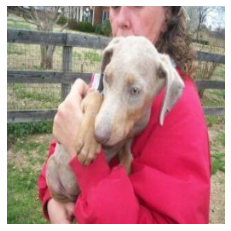

In [9]:
# train画像確認
i = np.random.randint(0, len(train))
img = cv2.imread(train["path"].iloc[i])

print("画像サイズ:", img.shape)
print("画像ラベル:", train["label"].iloc[i])

plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## validation-df

In [70]:
# val-df作成
val = pd.DataFrame(X_val, columns=["path"])
val["label"] = y_val
val = val.sort_values('path')

print("val-dfのsize:", val.shape)

val.head(3)

val-dfのsize: (5000, 2)


,path,label
2,/content/datasets/train_resize_256/cat.10.jpg,0
12,/content/datasets/train_resize_256/cat.10007.jpg,0
14,/content/datasets/train_resize_256/cat.10009.jpg,0


画像サイズ: (256, 256, 3)
画像ラベル: 0


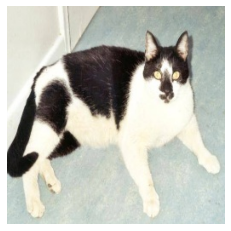

In [11]:
#val画像確認
i = np.random.randint(0, len(val))
img = cv2.imread(val["path"].iloc[i])

print("画像サイズ:", img.shape)
print("画像ラベル:", val["label"].iloc[i])

plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# batch-generator

In [12]:
# ランダムなデータ加工設定
IDG = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range = 15,        # 15度の画像回転まで許す
        #width_shift_range = .1,     # 水平方向ずらしを256 x 0.1= 25.6まで許す
        #height_shift_range = .1,    # 垂直方向ずらしを25.6まで許す
        #shear_range = .1,           # シアー変換を25.6まで許す(画像が斜めにゆがむ)
        #zoom_range = .1,            # 拡大縮小を0.1倍まで許す
        #vertical_flip=True          # 水平方向反転を許す
        #horizontal_flip=True        # 垂直方向反転を許す (逆さの犬や猫はいない気がする)
)

画像ラベル: 0


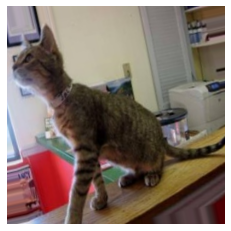

In [13]:
# batch生成
def batch_gen(df, batch_size, flag):
    while True:
        batch = df.sample(batch_size)

        batch_x = []
        batch_y = []

        for index, items in batch.iterrows():
            filepath = items[0]
            label = items[1]

            img = cv2.imread(filepath)
            img = np.array(img).astype('float32')/255

            batch_x.append(img)
            batch_y.append(label)


        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)

        if flag == 1:
            gen = IDG.flow(batch_x, batch_y, batch_size=batch_x.shape[0])
            batch_x, batch_y = gen.next()

        yield (batch_x, batch_y)

# 動作確認
batch_size = 64

train_gen = batch_gen(train, batch_size, 1) # この時点では関数は実行されない
x, y = next(train_gen)

i = np.random.randint(0, batch_size)
img = (x[i] * 255).astype('uint8')
print("画像ラベル:", y[i])
plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

画像ラベル: 1


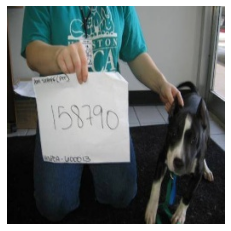

In [14]:
batch_size = 64

val_gen = batch_gen(val, batch_size, 0) # この時点では関数は実行されない
x, y = next(val_gen)

i = np.random.randint(0, batch_size)
img = (x[i] * 255).astype('uint8')
print("画像ラベル:", y[i])
plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# モデル構築

In [15]:
img_size = cv2.imread(train["path"][0]).shape[0]

input = Input(shape=(img_size, img_size, 3))

RN = ResNet50(
        include_top = False,    # 全結合を層を含むか否か
        weights = 'imagenet',
        input_tensor = input
)

top_model = Sequential()
top_model.add(Flatten(input_shape = RN.output_shape[1:], name='top_start'))
top_model.add(Dense(1024, activation='relu'))
top_model.add(BatchNormalization())
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(64, activation='relu'))
top_model.add(Dense(1, activation='sigmoid'))

full_model = Model(
        inputs = RN.input,
        outputs = top_model(RN.output))

full_model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_____________________________

In [16]:
# ResNetは以下設定が相性良好
full_model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.BinaryCrossentropy(), tf.keras.metrics.BinaryAccuracy()])

# early_stopping: val_lossが5epocで改善しない場合はstop
ES = tf.keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        patience = 5
)

# 学習

In [17]:
# 学習
steps = len(train) // batch_size
val_steps = len(val) // batch_size

full_model.fit(
        train_gen,
        steps_per_epoch = steps,           # 1epoch内のstep数(312) = data_size(20000) / batch_size(64) 
        validation_data = val_gen,
        validation_steps=val_steps,
        epochs = 20, 
        verbose = 1,
        callbacks = [ES]
)

Epoch 1/20
312/312 [==============================] - 347s 1s/step - loss: 0.0645 - binary_crossentropy: 0.0645 - binary_accuracy: 0.9739 - val_loss: 0.9864 - val_binary_crossentropy: 0.9864 - val_binary_accuracy: 0.4898
Epoch 2/20
312/312 [==============================] - 322s 1s/step - loss: 0.0259 - binary_crossentropy: 0.0259 - binary_accuracy: 0.9908 - val_loss: 0.3956 - val_binary_crossentropy: 0.3956 - val_binary_accuracy: 0.8183
Epoch 3/20
312/312 [==============================] - 327s 1s/step - loss: 0.0174 - binary_crossentropy: 0.0174 - binary_accuracy: 0.9939 - val_loss: 0.0601 - val_binary_crossentropy: 0.0601 - val_binary_accuracy: 0.9776
Epoch 4/20
312/312 [==============================] - 328s 1s/step - loss: 0.0104 - binary_crossentropy: 0.0104 - binary_accuracy: 0.9967 - val_loss: 0.0251 - val_binary_crossentropy: 0.0251 - val_binary_accuracy: 0.9914
Epoch 5/20
312/312 [==============================] - 323s 1s/step - loss: 0.0094 - binary_crossentropy: 0.0094 - bi

In [19]:
# モデル保存
#full_model.save("test2_model.h5")
print(os.path.getsize('test2_model.h5') * (10**-9), "GB")

!cp /content/test2_model.h5 /content/drive/MyDrive/project/Kaggle_Dogs_vs_Cats_Redux/trained_model/

1.26546556 GB
